In [1]:
import pickle, gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob, os
import re, ast
import itertools
import seaborn as sns
from matplotlib import rcParams
from qiskit.visualization import plot_histogram
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from seaborn import set_theme
from matplotlib import style

rcParams.update({'figure.autolayout': True})
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
#rc('text', usetex=True)
rcParams['text.usetex'] = True

#import warnings
#warnings.filterwarnings("ignore")

# New way to compute QVF (Michelson contrast)

In [2]:
# Compute the new QVF for the whole circuit, as well as for each available qubit
def compute_QVF_michelson_contrast(df, circuit_name, phi, theta):
    dfFilter = df[(df.circuit_name==circuit_name) & (df.phi==phi) & (df.theta==theta)]
    #print('computing QVF for',circuit_name)
    #print(dfFilter)
    QVF = {}
    QVF['QVF_circuit'] = dfFilter['QVF'].mean()
    #print(QVF['QVF_circuit'],sum(dfFilter['success']),len(dfFilter['success']))
    #print('-----------')
    
    qubits = set(dfFilter['qubit_injected'])    
    for q in qubits:
        QVF['QVF_qubit_'+str(q)] = dfFilter[dfFilter.qubit_injected==q]['QVF'].mean()
    #QVF['gold_ok'] = dfFilter['gold_success'][0]
    return QVF

In [3]:
def QVF_michelson_contrast(gold_bitstring, answer, shots):    
    # Sort the answer, position 0 has the highest bitstring, position 1 the second highest
    answer_sorted = sorted(answer, key=answer.get, reverse=True)
    
    # If gold bitstring is not in answer, percentage is zero
    if gold_bitstring not in answer:
        good_percent = 0
    else:
        good_percent = answer[gold_bitstring]/shots
        
    if answer_sorted[0] == gold_bitstring: # gold bitstring has the highest count (max)
        # next bitstring is the second highest
        next_percent = answer[answer_sorted[1]]/shots 
        next_bitstring = answer_sorted[1]
    else: # gold bitstring has NOT the highest count (not max)
        next_percent = answer[answer_sorted[0]]/shots 
        next_bitstring = answer_sorted[0]
    qvf = (good_percent - next_percent) / (good_percent + next_percent)    
    return 1 - (qvf+1)/2, next_bitstring
    
# Read pickled data and store results in a dataframe
def build_DF_newQVF(data):
    results = []
    shots = 1024
    gold_bitstring = max(data['output_gold_noise'], key=data['output_gold_noise'].get)#check
    original_gold_percentage = data['output_gold_noise'][gold_bitstring]/shots

    for i, answer in enumerate(data['output_injections_noise']):
        qvf, next_bitstring = QVF_michelson_contrast(gold_bitstring, answer, shots)
        max_key = max(answer, key=answer.get)
        output_percentage = answer[max_key]/shots
        #next_bitstring_percentage = answer[next_bitstring]/shots
        if gold_bitstring not in answer:
            gold_percentage = 0
        else:
            gold_percentage = answer[gold_bitstring]/shots
        result = {'QVF':qvf
                , 'qubit_injected':data['circuits_injections'][i].metadata['qubit']                
                , 'phi':data['circuits_injections'][i].metadata['phi']
                , 'theta':data['circuits_injections'][i].metadata['theta']
                #, 'lambda':data['circuits_injections'][i].metadata['lambda']
                #, 'gate_injected':data['circuits_injections'][i].metadata['gate_inserted']
                , 'circuit_name':data['name']
                #, 'gold_bitstring':gold_bitstring
                #, 'gold_count_percentage':gold_percentage
                #, 'original_gold_count_percentage':original_gold_percentage
                #, 'next_bitstring': next_bitstring
                #, 'next_bitstring_percentage': next_bitstring_percentage
                }
        results.append(result)
    return pd.DataFrame(results)

In [4]:
#u_gate_15degrees_step_bv_dj_10.p.gz   # Bernstein-Vazirani and Deutsch–Jozsa using 10 qubits
#u_gate_15degrees_step_bv_dj_4_5_6_7.p.gz  # Bernstein-Vazirani and Deutsch–Jozsa using 4, 5, 6, and 7 qubits
#u_gate_15degrees_step_qft_4_5_6_7.p.gz # Fourier Transform using 4, 5, 6, and 7 qubits

#'../results/double_fi_BV_4qubits.p.gz'
#'../results/u_gate_15degrees_step_bv_dj_10.p.gz'
#'../results/u_gate_15degrees_step_bv_dj_4_5_6_7.p.gz'
#'../results/u_gate_15degrees_step_qft_4_5_6_7_8_9_10_11.p.gz'
#'../results/u_gate_15degrees_step_qft_4_5_6_7.p.gz'

files_to_process = [
#'../results/u_gate_15degrees_step_bv_dj_10.p.gz', 
'../results/u_gate_15degrees_step_bv_dj_4_5_6_7.p.gz', 
'../results/u_gate_15degrees_step_qft_4_5_6_7_8_9_10_11.p.gz',  # it has only 4-7 qubits
#'../results/u_gate_15degrees_step_qft_4_5_6_7.p.gz',
]
# read all data and insert it into one dataframe
df_newQVF = pd.DataFrame()
for filename in files_to_process:
    data = pickle.load(gzip.open(filename, 'r'))
    
    for d in data:
        df_newQVF = pd.concat([df_newQVF, build_DF_newQVF(d)], ignore_index=True)
    del data

In [5]:
# Get available circuits and parameters used for injection (phi and theta)
phi_list = list(set(df_newQVF.phi))
phi_list.sort(reverse=True)
theta_list = list(set(df_newQVF.theta))
theta_list.sort()
circuits = list(set(df_newQVF.circuit_name))
circuits.sort()

In [6]:
results = []
for circuit in circuits:
    for phi in phi_list:
        for theta in theta_list:
            qvf = compute_QVF_michelson_contrast(df_newQVF, circuit, phi, theta)
            qvf['circuit_name'] = circuit
            qvf['phi'] = phi
            qvf['theta'] = theta
            #qvf['threshold'] = threshold
            results.append(qvf)

new_qvfDF_noise = pd.DataFrame(results)
new_qvfDF_noise = new_qvfDF_noise[sorted(list(new_qvfDF_noise.columns))]
new_qvfDF_noise
#compute_QVF_michelson_contrast

,QVF_circuit,QVF_qubit_0,QVF_qubit_1,QVF_qubit_2,QVF_qubit_3,QVF_qubit_4,QVF_qubit_5,QVF_qubit_6,circuit_name,phi,theta
0,0.052662,0.058335,0.051935,0.056867,0.045801,NaN,NaN,NaN,Bernstein-Vazirani_4,6.021386,0.000000
1,0.059125,0.061435,0.053775,0.063754,0.057934,NaN,NaN,NaN,Bernstein-Vazirani_4,6.021386,0.261799
2,0.098441,0.117461,0.079755,0.104798,0.093422,NaN,NaN,NaN,Bernstein-Vazirani_4,6.021386,0.523599
3,0.167285,0.186175,0.157316,0.177775,0.152728,NaN,NaN,NaN,Bernstein-Vazirani_4,6.021386,0.785398
4,0.253004,0.279699,0.255844,0.273511,0.215472,NaN,NaN,NaN,Bernstein-Vazirani_4,6.021386,1.047198
...,...,...,...,...,...,...,...,...,...,...,...
3739,0.551800,0.635285,0.524414,0.551749,0.511247,0.533033,0.486454,0.616363,inverseQFT7,0.000000,2.094395
3740,0.616570,0.692123,0.600008,0.625332,0.583553,0.605347,0.537909,0.668414,inverseQFT7,0.000000,2.356194
3741,0.653052,0.750229,0.624372,0.655116,0.621332,0.628730,0.594639,0.693771,inverseQFT7,0.000000,2.617994
3742,0.696407,0.786386,0.708484,0.693441,0.656974,0.664915,0.634869,0.725840,inverseQFT7,0.000000,2.879793


In [7]:
#### Without multiplication sign 'x'
# theta_list_tex = ['0', '$\\frac{\pi}{12}$', '$\\frac{\pi}{6}$', '$\\frac{\pi}{4}$', '$\\frac{\pi}{3}$', '$\\frac{5\pi}{12}$', '$\\frac{\pi}{2}$', '$\\frac{7\pi}{12}$'
#               , '$\\frac{4\pi}{6}$', '$\\frac{3\pi}{4}$', '$\\frac{5\pi}{6}$', '$\\frac{11\pi}{12}$', '$\pi$']
# phi_list_tex = ['$\\frac{23\pi}{12}$', '$\\frac{11\pi}{6}$', '$\\frac{7\pi}{4}$', '$\\frac{5\pi}{3}$', '$\\frac{19\pi}{12}$'
#             , '$\\frac{6\pi}{4}$', '$\\frac{17\pi}{12}$', '$\\frac{4\pi}{3}$', '$\\frac{5\pi}{4}$', '$\\frac{7\pi}{6}$'
#             , '$\\frac{13\pi}{12}$', '$\pi$', '$\\frac{11\pi}{12}$', '$\\frac{5\pi}{6}$',  '$\\frac{3\pi}{4}$'  
#             , '$\\frac{4\pi}{6}$', '$\\frac{7\pi}{12}$', '$\\frac{\pi}{2}$', '$\\frac{5\pi}{12}$', '$\\frac{\pi}{3}$', '$\\frac{\pi}{4}$'
#             , '$\\frac{\pi}{6}$', '$\\frac{\pi}{12}$', '0']


theta_list_tex = ['0', '', '', '$\\frac{\pi}{4}$', '', '', '$\\frac{\pi}{2}$', ''
                , '', '$\\frac{3\pi}{4}$', '', '', '$\pi$']
phi_list_tex = ['', '', '$\\frac{7\pi}{4}$', '', ''
            , '$\\frac{6\pi}{4}$', '', '', '$\\frac{5\pi}{4}$', ''
            , '', '$\pi$', '', '',  '$\\frac{3\pi}{4}$'  
            , '', '', '$\\frac{\pi}{2}$', '', '', '$\\frac{\pi}{4}$'
            , '', '', '0']


dirHeatmapPlots = '../plots/heatmaps/'
dirHistPlots = '../plots/histograms/'
if not os.path.exists(dirHeatmapPlots):
    os.makedirs(dirHeatmapPlots)
if not os.path.exists(dirHistPlots):
    os.makedirs(dirHistPlots)    
            
for circuit in circuits:
    # get a list of qubit columns (circuit may have different number of qubits now)
    colNames = new_qvfDF_noise[new_qvfDF_noise['circuit_name']==circuit].dropna(axis=1).columns    
    QVF_list= ['QVF_circuit']
    QVF_list.extend( [x for x in colNames if re.search('QVF_qubit_.*',x)] ) # uncomment this line to include individual qubit analysis
    
    for qvf_idx in QVF_list:
        qvf_tmp = new_qvfDF_noise[new_qvfDF_noise['circuit_name']==circuit]
        qvf_tmp = qvf_tmp.pivot('phi', 'theta', qvf_idx)
        qvf_tmp.columns.name = '$\\theta$ shift'
        qvf_tmp.index.name = '$\\phi$ shift'
        fig, ax = plt.subplots(1, 1, figsize=(5, 6))
        param={'label': 'QVF'}

        divnorm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
        rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=200, l=55, sep=20, as_cmap=True)
        sns.set(font_scale=1.3)
        
        ax = sns.heatmap(qvf_tmp, xticklabels=theta_list_tex, yticklabels=phi_list_tex, cbar_kws=param, vmin=0, vmax=1, center=0.5, cmap=rdgn)
        #ax = sns.heatmap(qvf_tmp, xticklabels=theta_list_tex, yticklabels=phi_list_tex, cmap="Greys", cbar_kws=param, vmin=0, vmax=1)
        
        plt.axhline(y=20.5, color="blue", linestyle="--")
        plt.text(13.25, 20.7, r'$T$', fontsize=10, color="blue")            #S at phi=pi/2
        plt.axhline(y=17.5, color="black", linestyle="--")
        plt.text(13.25, 17.7, r'$S$', fontsize=10, color="black")            #Z at phi=pi
        plt.axhline(y=11.5, color="cyan", linestyle="--")
        plt.text(13.25, 11.7, r'$Z$', fontsize=10, color="cyan")            #X,Y at theta=pi
        plt.axvline(x=12.5, color="purple", linestyle="--")
        plt.text(12, -0.5, r'$X, Y$', fontsize=10, color="purple")
        
        fig.savefig(dirHeatmapPlots+circuit+'_'+qvf_idx+'_heatmap.png', bbox_inches='tight')
        plt.close()

        
        all_values = []
        for column in qvf_tmp:
            this_column_values = qvf_tmp[column].tolist()
            all_values += this_column_values
        one_column_df = pd.DataFrame(all_values)

        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        sns.set(font_scale=1.3)
        ax = sns.distplot(qvf_tmp, bins=256, color='black')
        plt.xlim(0, 1)

        tmp_mean = one_column_df.mean()
        tmp_stddev = one_column_df.std()
        ax.get_yaxis().set_visible(False)
        tmpFileName = dirHistPlots+circuit+'_'+qvf_idx+'_distribution_histogram_'+str(tmp_mean[0])+'_'+str(tmp_stddev[0])+'.pdf'
        fig.savefig(tmpFileName, bbox_inches = 'tight')
        plt.close()

In [8]:
# Plot delta heatmaps
dirPlots = '../plots/deltaHeatmaps/'
if not os.path.exists(dirPlots):
    os.makedirs(dirPlots)

for circuit in circuits:
    # get a list of qubit columns (circuit may have different number of qubits now)
    colNames = new_qvfDF_noise[new_qvfDF_noise['circuit_name']==circuit].dropna(axis=1).columns    
    QVF_list =  [x for x in colNames if re.search('QVF_qubit_.*',x)]  # uncomment this line to include individual qubit analysis    
    
    for pair in itertools.combinations(QVF_list, 2):
            qvf_tmp = new_qvfDF_noise[new_qvfDF_noise['circuit_name']==circuit].copy()
            qvf_tmp['delta'] = qvf_tmp[pair[0]] - qvf_tmp[pair[1]]        
            qvf_tmp = qvf_tmp.pivot('phi', 'theta', 'delta')
            qvf_tmp.columns.name = '$\\theta$ shift'
            qvf_tmp.index.name = '$\\phi$ shift'
            fig, ax = plt.subplots(1, 1, figsize=(5, 6))
            label = '$\Delta$QVF = '+pair[0].replace('_','')+' - '+pair[1].replace('_','')
            param={'label': label}
            ax = sns.heatmap(qvf_tmp, xticklabels=theta_list_tex, yticklabels=phi_list_tex, cmap='seismic', cbar_kws=param, vmin=-1, vmax=1)            
            plt.axhline(y=20.5, color="blue", linestyle="--")       #T at phi=pi/4
            plt.text(13.25, 20.7, r'$T$', fontsize=10, color="blue")            
            plt.axhline(y=17.5, color="black", linestyle="--")      #S at phi=pi/2  
            plt.text(13.25, 17.7, r'$S$', fontsize=10, color="black")       
            plt.axhline(y=11.5, color="cyan", linestyle="--")       #Z at phi=pi   
            plt.text(13.25, 11.7, r'$Z$', fontsize=10, color="cyan")          
            plt.axvline(x=12.5, color="purple", linestyle="--")     #X,Y at theta=pi
            plt.text(12, -0.5, r'$X, Y$', fontsize=10, color="purple")
            fig.savefig(dirPlots+circuit+'_'+pair[0]+'-'+pair[1]+'_delta_heatmap.pdf', bbox_inches='tight')
            plt.close()


# Distribution plots merging different circuit size (number of qubits)

name: inverseQFT4  mean: 0.4459565347544145  std: 0.1600444457801103
name: inverseQFT5  mean: 0.4597963828875652  std: 0.142462854042321
name: inverseQFT6  mean: 0.46490646987853335  std: 0.12495295890474696
name: inverseQFT7  mean: 0.49074114286966963  std: 0.10387502367980883

name: Bernstein-Vazirani_4  mean: 0.4698874615644132  std: 0.18867501091017166
name: Bernstein-Vazirani_5  mean: 0.4723921195058169  std: 0.1875599237415098
name: Bernstein-Vazirani_6  mean: 0.4810197644757403  std: 0.19080933898343316
name: Bernstein-Vazirani_7  mean: 0.4818236607732514  std: 0.19176520586848061

name: Deutsch-Jozsa_4  mean: 0.48383137008900506  std: 0.19350280942818718
name: Deutsch-Jozsa_5  mean: 0.4912121390387333  std: 0.1908156407402926
name: Deutsch-Jozsa_6  mean: 0.49548826891010667  std: 0.19453640734763764
name: Deutsch-Jozsa_7  mean: 0.5013155758120311  std: 0.1888069870869493



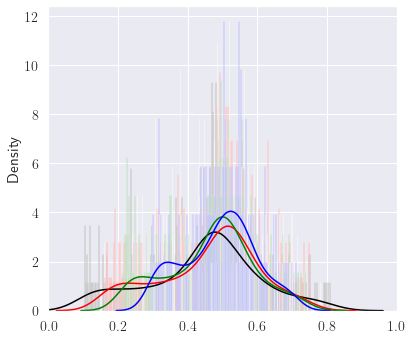

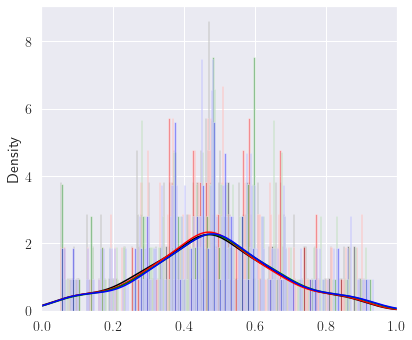

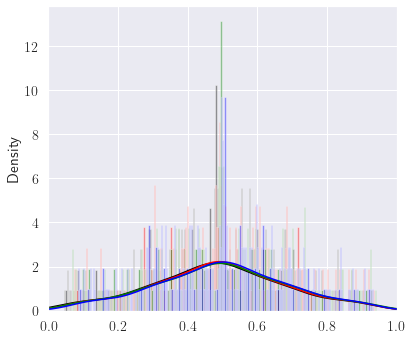

In [38]:
dirHistPlots = '../plots/histograms/'
if not os.path.exists(dirHistPlots):
    os.makedirs(dirHistPlots) 

circuitsTuples = [('QFT', ['inverseQFT4', 'inverseQFT5', 'inverseQFT6', 'inverseQFT7']), 
                 ('Bernstein-Vazirani', ['Bernstein-Vazirani_4', 'Bernstein-Vazirani_5', 'Bernstein-Vazirani_6', 'Bernstein-Vazirani_7']), 
                 ('Deutsch-Jozsa', ['Deutsch-Jozsa_4', 'Deutsch-Jozsa_5', 'Deutsch-Jozsa_6', 'Deutsch-Jozsa_7']), 
                 ]
for t in circuitsTuples:
    circs = t[1]
    circname = t[0]

    qvf_tmp = list()
    for i, name in enumerate(circs):
        qvf_tmp.append(new_qvfDF_noise[new_qvfDF_noise['circuit_name']==name])
        qvf_tmp[i] = qvf_tmp[i].pivot('phi', 'theta', 'QVF_circuit')
        qvf_tmp[i].columns.name = '$\\theta$ shift'
        qvf_tmp[i].index.name = '$\\phi$ shift'
        
        all_values = []
        for column in qvf_tmp[i]:
            this_column_values = qvf_tmp[i][column].tolist()
            all_values += this_column_values
        one_column_df = pd.DataFrame(all_values)
        print('name:',name,' mean:',one_column_df.mean()[0],' std:',one_column_df.std()[0])
    print()

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    sns.set(font_scale=1.3)
    #ax = 
    colors = ['black', 'red', 'green', 'blue']
    for i, data in enumerate(qvf_tmp):
        sns.distplot(data, bins=256, color=colors[i])
    #sns.distplot(qvf_tmp2, bins=256, color='red')
    plt.xlim(0, 1)
    
    tmpFileName = dirHistPlots+circname+'_distribution_histogram'+'.pdf'
    fig.savefig(tmpFileName, bbox_inches = 'tight')
    plt.close()
    #print(tmpFileName)